#### This notebook contains the code for computing the evolvability vectors and their archetypal representations

### General Imports and model loading

In [1]:

import sys
sys.path.insert(0, '../')
import aux
from aux import *
#%load_ext autoreload
#%autoreload 2
##Clear Memory 
tf.reset_default_graph()
tf.keras.backend.clear_session()
gc.collect()
##


if 1 : 
    NUM_GPU = len(get_available_gpus())
    if(NUM_GPU>0) :
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

    print(tf.__version__)
    print(keras.__version__)
    #tpu_grpc_url = TPUClusterResolver(tpu=['edv-tpu2'] , zone='us-central1-a').get_master()
    color_codes = pd.read_csv('../color_codes.tsv' , sep=',',index_col=0)






    ### Load the Model in a separate graph here as there are two models in this figure.
    fitness_function_graph = tf.Graph()
    with fitness_function_graph.as_default():
        model_conditions='SC_Ura'
        model, scaler,batch_size = load_model(model_conditions)

W1127 00:13:30.894981 47575410753152 deprecation_wrapper.py:119] From ../aux.py:30: The name tf.keras.layers.CuDNNLSTM is deprecated. Please use tf.compat.v1.keras.layers.CuDNNLSTM instead.



1.14.0
2.2.4-tf


/ahg/regevdata/users/edv/software/anaconda3/envs/me/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
W1127 00:14:16.765298 47575410753152 deprecation.py:506] From /ahg/regevdata/users/edv/software/anaconda3/envs/me/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1288: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W1127 00:14:18.596938 47575410753152 deprecation.py:506] From /ahg/regevdata/users/edv/software/anaconda3/envs/me/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:97: calling Orthogonal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecat

### Other Functions and Imports

In [2]:
##AAnet implementation thanks to code shared by https://github.com/KrishnaswamyLab/AAnet 
## The version of AAnet we used here is available in this folder

import AAnet.AAnet as AAnet
import AAnet.network as network
import AAnet.AAtools as AAtools
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors
##AAnet
args  = {'sequence_length' : 80}

np.random.seed(0)

color_codes = pd.read_csv('../color_codes.tsv' , sep=',',index_col=0)

#########################################################################################################
#########################################################################################################
### Generate all possible single mutations in population : population_next 


def population_mutator( population_current , args) :
    population_current = population_remove_flank(population_current)
    population_next = []  
    for i in range(len(population_current)) :         
        for j in range(args['sequence_length']) : 
        #First create three copies of the same individual, one for each possible mutation at the basepair.
            population_next.append(list(population_current[i]))
            population_next.append(list(population_current[i]))
            population_next.append(list(population_current[i]))
            
            if (population_current[i][j] == 'A') :
                population_next[3*(args['sequence_length']*i + j) ][j] = 'C'
                population_next[3*(args['sequence_length']*i + j) + 1][j] = 'G'
                population_next[3*(args['sequence_length']*i + j) + 2][j] = 'T'
                
            elif (population_current[i][j] == 'C') :
                population_next[3*(args['sequence_length']*i + j)][j] = 'A'
                population_next[3*(args['sequence_length']*i + j) + 1][j] = 'G'
                population_next[3*(args['sequence_length']*i + j) + 2][j] = 'T'
            
            elif (population_current[i][j] == 'G') :
                population_next[3*(args['sequence_length']*i + j)][j] = 'C'
                population_next[3*(args['sequence_length']*i + j) + 1][j] = 'A'
                population_next[3*(args['sequence_length']*i + j) + 2][j] = 'T'
                
            elif (population_current[i][j] == 'T') :
                population_next[3*(args['sequence_length']*i + j)][j] = 'C'
                population_next[3*(args['sequence_length']*i + j) + 1][j] = 'G'
                population_next[3*(args['sequence_length']*i + j) + 2][j] = 'A'
             
        
    population_next= population_add_flank(population_next)        
    return list(population_next)





#########################################################################################################
#########################################################################################################
#########################################################################################################




#######################################################################################
#######################################################################################
#######################################################################################

def closest_point(node, nodes):
    nodes = np.asarray(nodes)
    deltas = nodes - node
    dist_2 = np.einsum('ij,ij->i', deltas, deltas)
    return np.argmin(dist_2)

#######################################################################################
#######################################################################################
#######################################################################################

def get_snpdev_dist(population) : 
    population_fitness = np.array(evaluate_model(list(population),model,scaler,batch_size,fitness_function_graph))
    args  = {'sequence_length' : 80 , 'nucleotide_frequency' :[0.25,0.25,0.25,0.25] , 'randomizer' : np.random } 
    population_1bp_all_sequences = population_mutator(list(population) , args)
    population_1bp_all_fitness = np.array(evaluate_model(list(population_1bp_all_sequences),model,scaler,batch_size,fitness_function_graph))


    snpdev_dist = []
    for i in (range(len(population))) :   
        original_fitness = population_fitness[i]
        sequence = population[i]

        exp_dist = population_1bp_all_fitness[3*args['sequence_length']*i:3*args['sequence_length']*(i+1)]
        snpdev_dist = snpdev_dist + [np.sort((exp_dist-original_fitness))]

    sequences = population
    return snpdev_dist


#######################################################################################
#######################################################################################
#######################################################################################


def analyze_seq(population ) : 
    ### Quick function to generate an analyzed dataframe for any sequence. Only works in this NB.

    data_at = AAnet_model.data2at(get_snpdev_dist(population))
    Y_mds_data = data_at @ Y_mds_ats
    
    data_at_df = pd.DataFrame(data_at , columns = ['AT1','AT2','AT3']).join(
    pd.DataFrame(Y_mds_data , columns = ['MDS1','MDS2'])).join(
    pd.DataFrame(evaluate_model(population,model,scaler,batch_size,fitness_function_graph),
                 columns = [model_conditions+'_exp']))
    return data_at_df, data_at , Y_mds_data
#######################################################################################
#######################################################################################
#######################################################################################


def snpdev_str_to_list(snpdev_str) : 
    return [float(i) for i in snpdev_str.replace("\n" , "").replace("[","").replace("]","").split()]



In [3]:
%matplotlib inline

#### Pick between random/native for the next plots

In [4]:
if 0 : 
    ### Native Sequences
    native_sequences_df = pd.read_csv(os.path.join('..','..','data','native_sequences_only','nativeChunks.2.uniq.txt') , header=None) #pd.read_csv(os.path.join('..','..','data','native_sequences_only','native_sequences.txt') , sep='\t', index_col=0, header=None)
    native_sequences = population_add_flank(list(native_sequences_df[0]))#list(native_sequences_df[1])

    r_n = "native"

    evaluate_model(native_sequences,model,scaler,batch_size,fitness_function_graph)

### Generate the training data for evolvability vectors
The evolvability vector is reffered to as snpdev_dist in the code

In [5]:
%%time
if 0: 
    sequences = []
    snpdev_dist = []
    args  = {'num_rounds' : 1 , 'population_size' : int(1e6) , 'sequence_length' : 80 , 'nucleotide_frequency' :[0.25,0.25,0.25,0.25] , 'randomizer' : np.random } 
    
    if(r_n) == 'random' : 
        population =  population_generator( args )    
    if(r_n) == 'native' : 
        population =  native_sequences     
    
    population_fitness = np.array(evaluate_model(list(population),model,scaler,batch_size,fitness_function_graph))

    population_1bp_all_sequences = population_mutator(list(population) , args)
    population_1bp_all_fitness = np.array(evaluate_model(list(population_1bp_all_sequences),model,scaler,batch_size,fitness_function_graph))


    snpdev_dist = []
    for i in (range(len(population))) :   
        original_fitness = population_fitness[i]
        sequence = population[i]

        exp_dist = population_1bp_all_fitness[3*args['sequence_length']*i:3*args['sequence_length']*(i+1)]
        snpdev_dist = snpdev_dist + [np.sort((exp_dist-original_fitness))]

    sequences = population
    #snpdev_dist = np.asarray(snpdev_dist)



    np.save('./' + model_conditions + '_1bp_'+r_n+'_sequences.npy' ,(sequences), allow_pickle=True   )
    np.save('./' + model_conditions + '_1bp_'+r_n+'_snpdev_dist.npy' ,(snpdev_dist), allow_pickle=True   )


else : 
    random_sequences = np.load('./' + model_conditions + '_1bp_random_sequences.npy' , allow_pickle=True)
    random_snpdev_dist = np.load('./' + model_conditions + '_1bp_random_snpdev_dist.npy' , allow_pickle=True)

    native_sequences = np.load('./' + model_conditions + '_1bp_native_sequences.npy' , allow_pickle=True)
    native_snpdev_dist = np.load('./' + model_conditions + '_1bp_native_snpdev_dist.npy' , allow_pickle=True)



CPU times: user 90.2 ms, sys: 1.51 s, total: 1.6 s
Wall time: 23.6 s


In [6]:
random_data = np.asarray(random_snpdev_dist) #data_all[idx_digit,]
native_data = np.asarray(native_snpdev_dist)
data = np.concatenate((native_data,random_data))

# AAnet parameters:
# this will create the following autoencoder: input -> 256 -> 64 -> 2 -> 64 -> 256 -> output
# note that 3 archetypes is encoded by 2 nodes
num_at = 3# number of archetypes
noise_z_std = 0.0 # noise added to archetype layer during training
z_dim = [1024,512, 256, 128 , 64] # encoder architecture, decoder has same but reverse architecture
act_out = tf.keras.activations.linear # activation of output layer
input_dim = data.shape[1] # dimensions of input data
gamma_mse = 1.0 # mean squared error constraint
gamma_nn = 1.0 # non negative constraint
gamma_convex = 1.0 # convex constraint
learning_rate = 1e-3 # adam learning rate
gpu_mem = 0.9# request fraction of total available gpu memory
at_model_filename = './AAnet_model/'+model_conditions



#### Select the right n_at 

/ahg/regevdata/users/edv/software/anaconda3/envs/me/lib/python3.6/site-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')
/ahg/regevdata/users/edv/software/anaconda3/envs/me/lib/python3.6/site-packages/matplotlib/axes/_base.py:3610: MatplotlibDeprecationWarning: 
The `ymax` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `top` instead.
  alternative='`top`', obj_type='argument')
/ahg/regevdata/users/edv/software/anaconda3/envs/me/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


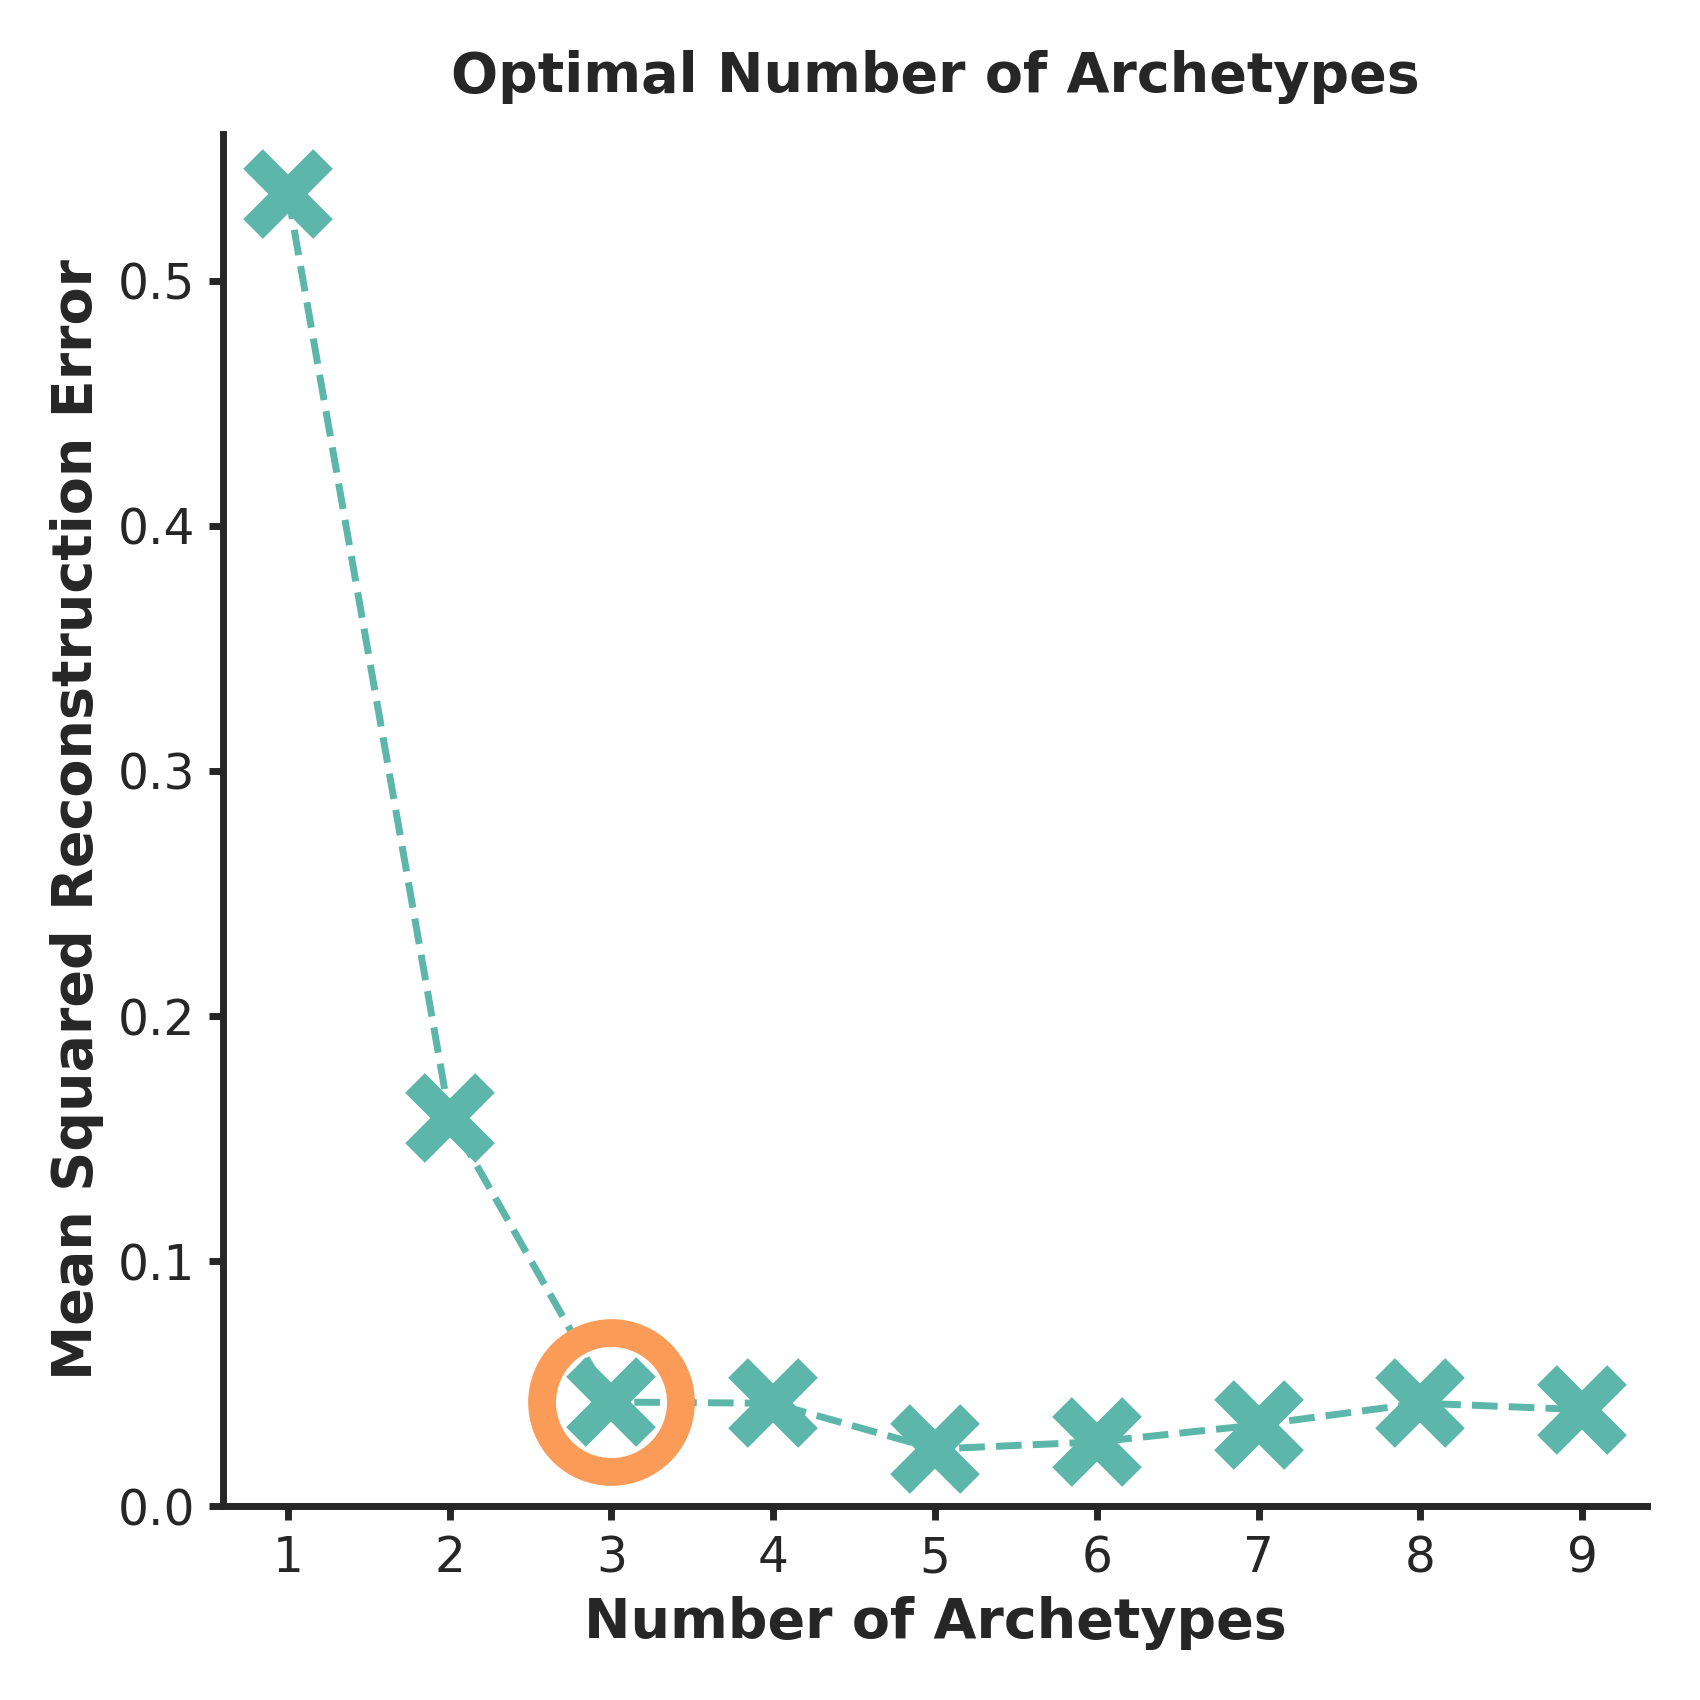

In [7]:
if 0 : 
    n_at_set = []
    loss = []

    for i in tqdm(range(1,10,1)) : 
        # construct network
        tf.reset_default_graph()
        enc_net = network.Encoder(num_at=i, z_dim=z_dim)
        dec_net = network.Decoder(x_dim=input_dim, noise_z_std=noise_z_std, z_dim=z_dim, act_out=act_out)


        n_at_model = AAnet.AAnet(enc_net, dec_net, learning_rate=learning_rate, gpu_mem=gpu_mem , 
                            gamma_mse=gamma_mse , gamma_convex=gamma_convex)

        n_at_model.train(random_data, batch_size=np.power(2,12), num_batches=1000, 
                          filename = './n_at_model/'+model_conditions+'_'+str(i))



        n_at_set = n_at_set + [i]
        loss = loss + [n_at_model.compute_mse_loss(native_data)]

    n_at_df = pd.DataFrame( {'Number of Archetypes' : n_at_set , 'Mean Squared Error' : loss})
    n_at_df.to_csv('n_at.tsv' , sep='\t')
n_at_df =  pd.read_csv('n_at.tsv' , sep='\t' , index_col=0)



### Plot
fig_file = "n_at"
fig=plt.figure(figsize=(3.5,3.5), dpi= 500, facecolor='w', edgecolor='k')
fig.tight_layout(pad = 1)

plt.plot( n_at_df['Number of Archetypes'] , n_at_df['Mean Squared Error'], '--', linewidth=1,
                color=color_codes.loc['green_neutral_evolution'].values , marker = 'x' , mew=4 ,ms=10)
plt.plot( n_at_df['Number of Archetypes'][2] , n_at_df['Mean Squared Error'][2],
                color=color_codes.loc['yellow_optimal_n_at'].values , marker = 'o', mew=4 , ms=20, mfc='None')

### Axes adjustments and Titles

ax = plt.gca()
ax.set_xlabel("Number of Archetypes"  )
ax.set_ylabel("Mean Squared Reconstruction Error")
ax.set_title("Optimal Number of Archetypes")
ax.set_xticks(n_at_df['Number of Archetypes'])
ax.set_ylim(ymin=0,ymax=0.56)


#ax.autoscale(enable=True, axis='x', tight=True)
#ax.autoscale(enable=True, axis='y', tight=True)

plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")
plt.show()




### dont facet by color , change the X axis to say unrelated sequences (remove lenged) ... make all the same color



#### Train/Load the full model with the correct n_at 

In [8]:
save_new_model=0
# construct network
tf.reset_default_graph()
enc_net = network.Encoder(num_at=num_at, z_dim=z_dim)
dec_net = network.Decoder(x_dim=input_dim, noise_z_std=noise_z_std, z_dim=z_dim, act_out=act_out)
AAnet_model = AAnet.AAnet(enc_net, dec_net, learning_rate=learning_rate, gpu_mem=gpu_mem , 
                    gamma_mse=gamma_mse , gamma_convex=gamma_convex)

# train/load AAnet
if ( save_new_model==1 ) :
    AAnet_model.train(random_data, batch_size=np.power(2,12), num_batches=250000, filename = at_model_filename)

else : 
    ## Load Model
    AAnet_model = AAnet.AAnet(enc_net, dec_net, learning_rate=learning_rate, gpu_mem=gpu_mem , 
                    gamma_mse=gamma_mse , gamma_convex=gamma_convex , load_existing=1 , filename = at_model_filename)

W1127 00:15:09.801569 47575410753152 deprecation_wrapper.py:119] From /ahg/regevdata/projects/GeneRegModeling/edv_generegmodelling/genereg_nn/paper/code/figure_archetypes/AAnet/AAnet.py:25: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1127 00:15:09.804864 47575410753152 deprecation_wrapper.py:119] From /ahg/regevdata/projects/GeneRegModeling/edv_generegmodelling/genereg_nn/paper/code/figure_archetypes/AAnet/AAnet.py:41: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1127 00:15:09.807142 47575410753152 deprecation_wrapper.py:119] From /ahg/regevdata/projects/GeneRegModeling/edv_generegmodelling/genereg_nn/paper/code/figure_archetypes/AAnet/network.py:18: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1127 00:15:09.808204 47575410753152 deprecation.py:323] From /ahg/regevdata/projects/GeneRegModeling/edv_generegmodelling/genereg_nn/paper/code/figure

In [9]:
AAnet_model.data2at(native_data)

array([[0.26843342, 0.20837492, 0.5231917 ],
       [0.34410483, 0.43277255, 0.2231226 ],
       [0.22267032, 0.38807112, 0.38925856],
       ...,
       [0.3260575 , 0.32245883, 0.3514837 ],
       [0.35181528, 0.32931262, 0.3188721 ],
       [0.37655154, 0.3794788 , 0.24396968]], dtype=float32)

#### Calculate/load projection for the random/native data to the same AT space and perform MDS + interpolation

In [10]:
if 0 : 
    mds , Y_mds_ats , random_data_at , random_Y_mds_data   = AAnet_model.get_at_mds(random_data)
    native_data_at = AAnet_model.data2at(native_data)
    native_Y_mds_data = native_data_at @ Y_mds_ats

    with open("mds.pkl","wb") as f:
        pickle.dump(mds, f)
        pickle.dump(Y_mds_ats, f)

        pickle.dump(random_data_at, f)
        pickle.dump(random_Y_mds_data, f)

        pickle.dump(native_data_at, f)
        pickle.dump(native_Y_mds_data, f)

else :
    with open("mds.pkl","rb") as f:
        mds=pickle.load(f)
        Y_mds_ats=pickle.load(f)

        random_data_at=pickle.load(f)
        random_Y_mds_data=pickle.load(f)

        native_data_at=pickle.load(f)
        native_Y_mds_data=pickle.load(f)
        
        

/ahg/regevdata/users/edv/software/anaconda3/envs/me/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator MDS from version 0.21.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


#### Make analyzed data frame for Random Sequences

In [11]:
if 0 : 
    random_snpdev_dist_from_at = AAnet_model.at2data(random_data_at)
    random_at_df = pd.DataFrame(random_data_at, index=random_sequences , columns = ['AT1','AT2','AT3']).join(
            pd.DataFrame(random_Y_mds_data, index=random_sequences , columns = ['MDS1','MDS2'])).join(pd.DataFrame(
                [str(random_snpdev_dist_from_at[i,:]) for i in tqdm(range(random_snpdev_dist_from_at.shape[0])) ], 
                index=random_sequences , columns = ['snpdev_dist_from_at']))
    random_at_df.to_csv('random_at_df.tsv' , sep='\t')

else : 
    random_at_df =  pd.read_csv('random_at_df.tsv' , sep='\t' , index_col=0)



#### Make analyzed data frame for Native Sequences

In [12]:
if 0 : 
    #native_at_df = pd.DataFrame(native_data_at, index=native_sequences , columns = ['AT1','AT2','AT3']).join(
    #    pd.DataFrame(native_Y_mds_data, index=native_sequences , columns = ['MDS1','MDS2'])).join(
    #    pd.DataFrame(evaluate_model(native_sequences,model,scaler,batch_size,fitness_function_graph), 
    #                 index=native_sequences , columns = [model_conditions+'_exp']))
    
    native_at_df,_,__ = analyze_seq(native_sequences)
    native_at_df['native_sequences'] = native_sequences
    #native_at_df['snpdev_dist'] = get_snpdev_dist(native_at_df.index.values) 
    native_at_df.to_csv('native_at_df.tsv' , sep='\t')


else : 
    native_at_df =  pd.read_csv('native_at_df.tsv' , sep='\t' , index_col=0)


#analyze_seq can't be used (non unique) and not needed here since snpdev_dist has already been generated above and stored in native_adata_at ,

#### Make analyzed data frame for Orthologous Sequences

In [13]:
if 0 : 
    ortho_sequences_df = pd.read_csv('/ahg/regevdata/projects/GeneRegModeling/SingleCellPGM/GPRA/Evolution/1002_yeast_genomes/analysis/20190719_Native80.2_orthologous_promoters_unique.txt.gz', sep='\t')
    ortho_sequences = list(ortho_sequences_df['ortho_seq'].values)
    if len(ortho_sequences[0])==80 :
        ortho_sequences = population_add_flank(list(ortho_sequences))
    ortho_at_df, data_at , Y_mds_data = analyze_seq(ortho_sequences)
    print(ortho_sequences)
    ortho_at_df = copy.deepcopy(ortho_sequences_df)
    ortho_at_df['AT1'] = data_at[:,0]
    ortho_at_df['AT2'] = data_at[:,1]
    ortho_at_df['AT3'] = data_at[:,2]

    ortho_at_df['MDS1'] = Y_mds_data[:,0]
    ortho_at_df['MDS2'] = Y_mds_data[:,1]
    ortho_at_df[model_conditions+'_exp']= evaluate_model(ortho_sequences,model,scaler,batch_size,fitness_function_graph)
    print(ortho_sequences)


    ortho_at_df['snpdev_dist'] = get_snpdev_dist(ortho_sequences) 
    ortho_at_df.to_csv('ortho_at_df.tsv' , sep='\t')
    ### Add the Native matching id from the ortho_sequences_df to the saved file
else : 
    ortho_at_df =  pd.read_csv('ortho_at_df.tsv' , sep='\t' , index_col=0)



In [14]:
Y_mds_ats

array([[-26.99564317,  -7.25776564],
       [ 29.82203504,  -3.18921039],
       [ -2.82639187,  10.44697603]])

#### Plot the at_space

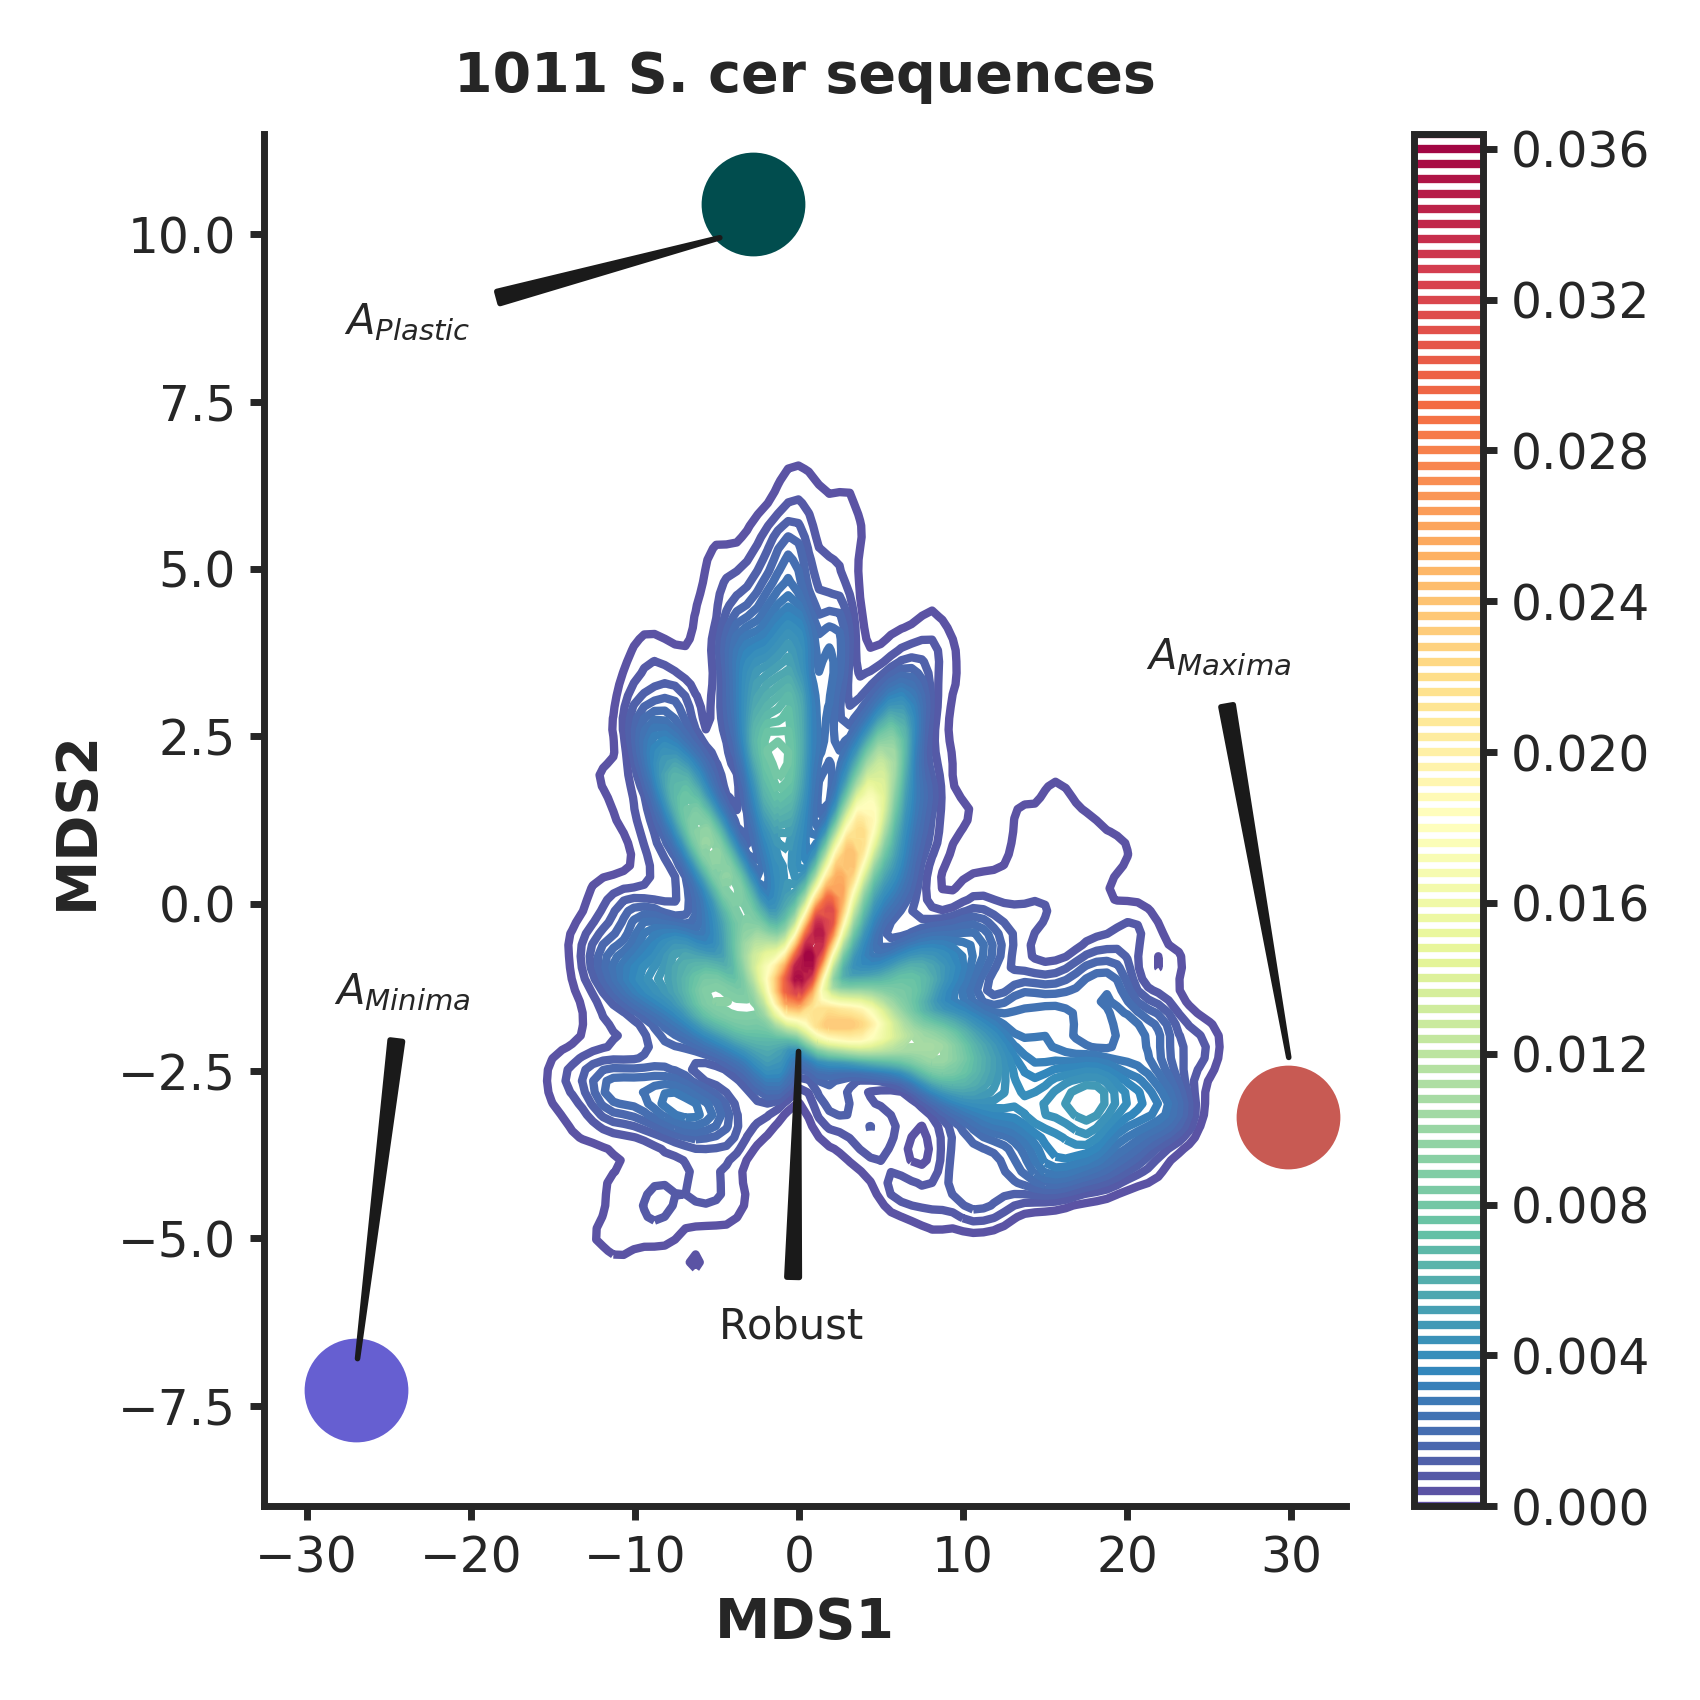

In [17]:
### Plot
#sns.set_palette( sns.color_palette('Spectral' )) 
at_colors = ['#665fd1' , '#c85a53', '#014d4e' ]
#color_palette = sns.choose_cubehelix_palette()

num_at=3

fig_file = "at_space"
fig=plt.figure(figsize=(3.5,3.5), dpi=500, facecolor='w', edgecolor='k')
#at_df = gc_balanced_random_at_df.loc[gc_balanced_random_at_df.iloc[0:len(ortho_at_df)].index] #ortho_at_df #random_at_df#
#at_df = random_at_df.loc[random_at_df.iloc[0:len(ortho_at_df)].index] #ortho_at_df #random_at_df#
at_df = ortho_at_df #random_at_df#


if 0 :
    MDS1_nonunique_list = []
    MDS2_nonunique_list = []

    for i in tqdm(at_df.index) : 
        MDS1_nonunique_list +=  list(np.tile(at_df.loc[i,'MDS1'] , 2) ) # at_df.loc[i,'num_isolates'])
        MDS2_nonunique_list +=  list(np.tile(at_df.loc[i,'MDS2'] , 2)  )# at_df.loc[i,'num_isolates'])



    #plt.hexbin(at_df['MDS1'] , at_df['MDS2'],gridsize=250, bins='log', mincnt=1,
    #          cmap = sns.dark_palette("pale orange", input="xkcd" , reverse=False, as_cmap=1))
    sns.kdeplot(MDS1_nonunique_list, MDS2_nonunique_list, 
                cmap = sns.diverging_palette(240, 10, n=10 , as_cmap=1 ,center="dark") ,
                n_levels=100, shade=False);

if 1 : 
    sns.kdeplot(at_df['MDS1'], at_df['MDS2'], 
                    cmap = 'Spectral_r' , cbar=1,
                    n_levels=100, shade=False);
    
if 0 :
    sns.jointplot(at_df['MDS1'], at_df['MDS2'], kind="hex",bins=1000,mincnt=1,
                  cmap = sns.diverging_palette(240, 10, n=10 , as_cmap=1 ,center="dark"))

#sns.jointplot(at_df['MDS1'], at_df['MDS2'], kind='hex')

if 1 : 
    for at in range(num_at) : 
        plt.scatter(Y_mds_ats[at,0], Y_mds_ats[at,1], s=200, c=at_colors[at], zorder=3 , marker='o')
        #plt.text(Y_mds_ats[at,0], Y_mds_ats[at,1], at+1, horizontalalignment='center', verticalalignment='center', 
        #     fontdict={'color': 'white','size':10,'weight':'bold'}, zorder=4)

    plt.scatter(Y_mds_ats[0,0], Y_mds_ats[0,1]-5, s=1, c='w', zorder=3)


#plt.scatter(cleft[0][0], cleft[0][1], s=200, c='w', zorder=3 , marker='o')

#TDH3 = ortho_at_df[ortho_at_df.proName=='YGR192C.2'].loc[:,['MDS1','MDS2']].values

#plt.scatter(TDH3[:,0] , TDH3[:,1])

### Axes adjustments and Titles

ax = plt.gca()
#ax.get_legend().remove()

ax.annotate('Robust', xy=(0, -2),  xycoords='data', fontsize=6,
            xytext=(4, -6), textcoords='data',
            arrowprops=dict(arrowstyle='wedge' , color='k'),
            horizontalalignment='right', verticalalignment='top'
            )
if 1 :
    ax.annotate('$A_{Plastic}$', xy=(-4, 10),  xycoords='data', fontsize=6,
                xytext=(-20, 9), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )

    ax.annotate('$A_{Maxima}$', xy=(30, -2.5),  xycoords='data', fontsize=6,
                xytext=(30, 4), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )


    ax.annotate('$A_{Minima}$', xy=(-27, -7),  xycoords='data', fontsize=6,
                xytext=(-20, -1), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )



ax.set_xlabel("MDS1"  )
ax.set_ylabel("MDS2")
ax.set_title("1011 S. cer sequences")

#ax.set_xticks([])
#ax.set_yticks([])
#ax.autoscale(enable=True, axis='x', tight=True)
#ax.autoscale(enable=True, axis='y', tight=True)
#plt.draw()
#ax.set_xlim(xmin=-14,xmax=6)
ax.set_ylim(ymin=-9,ymax=11.5)


plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")


plt.show()



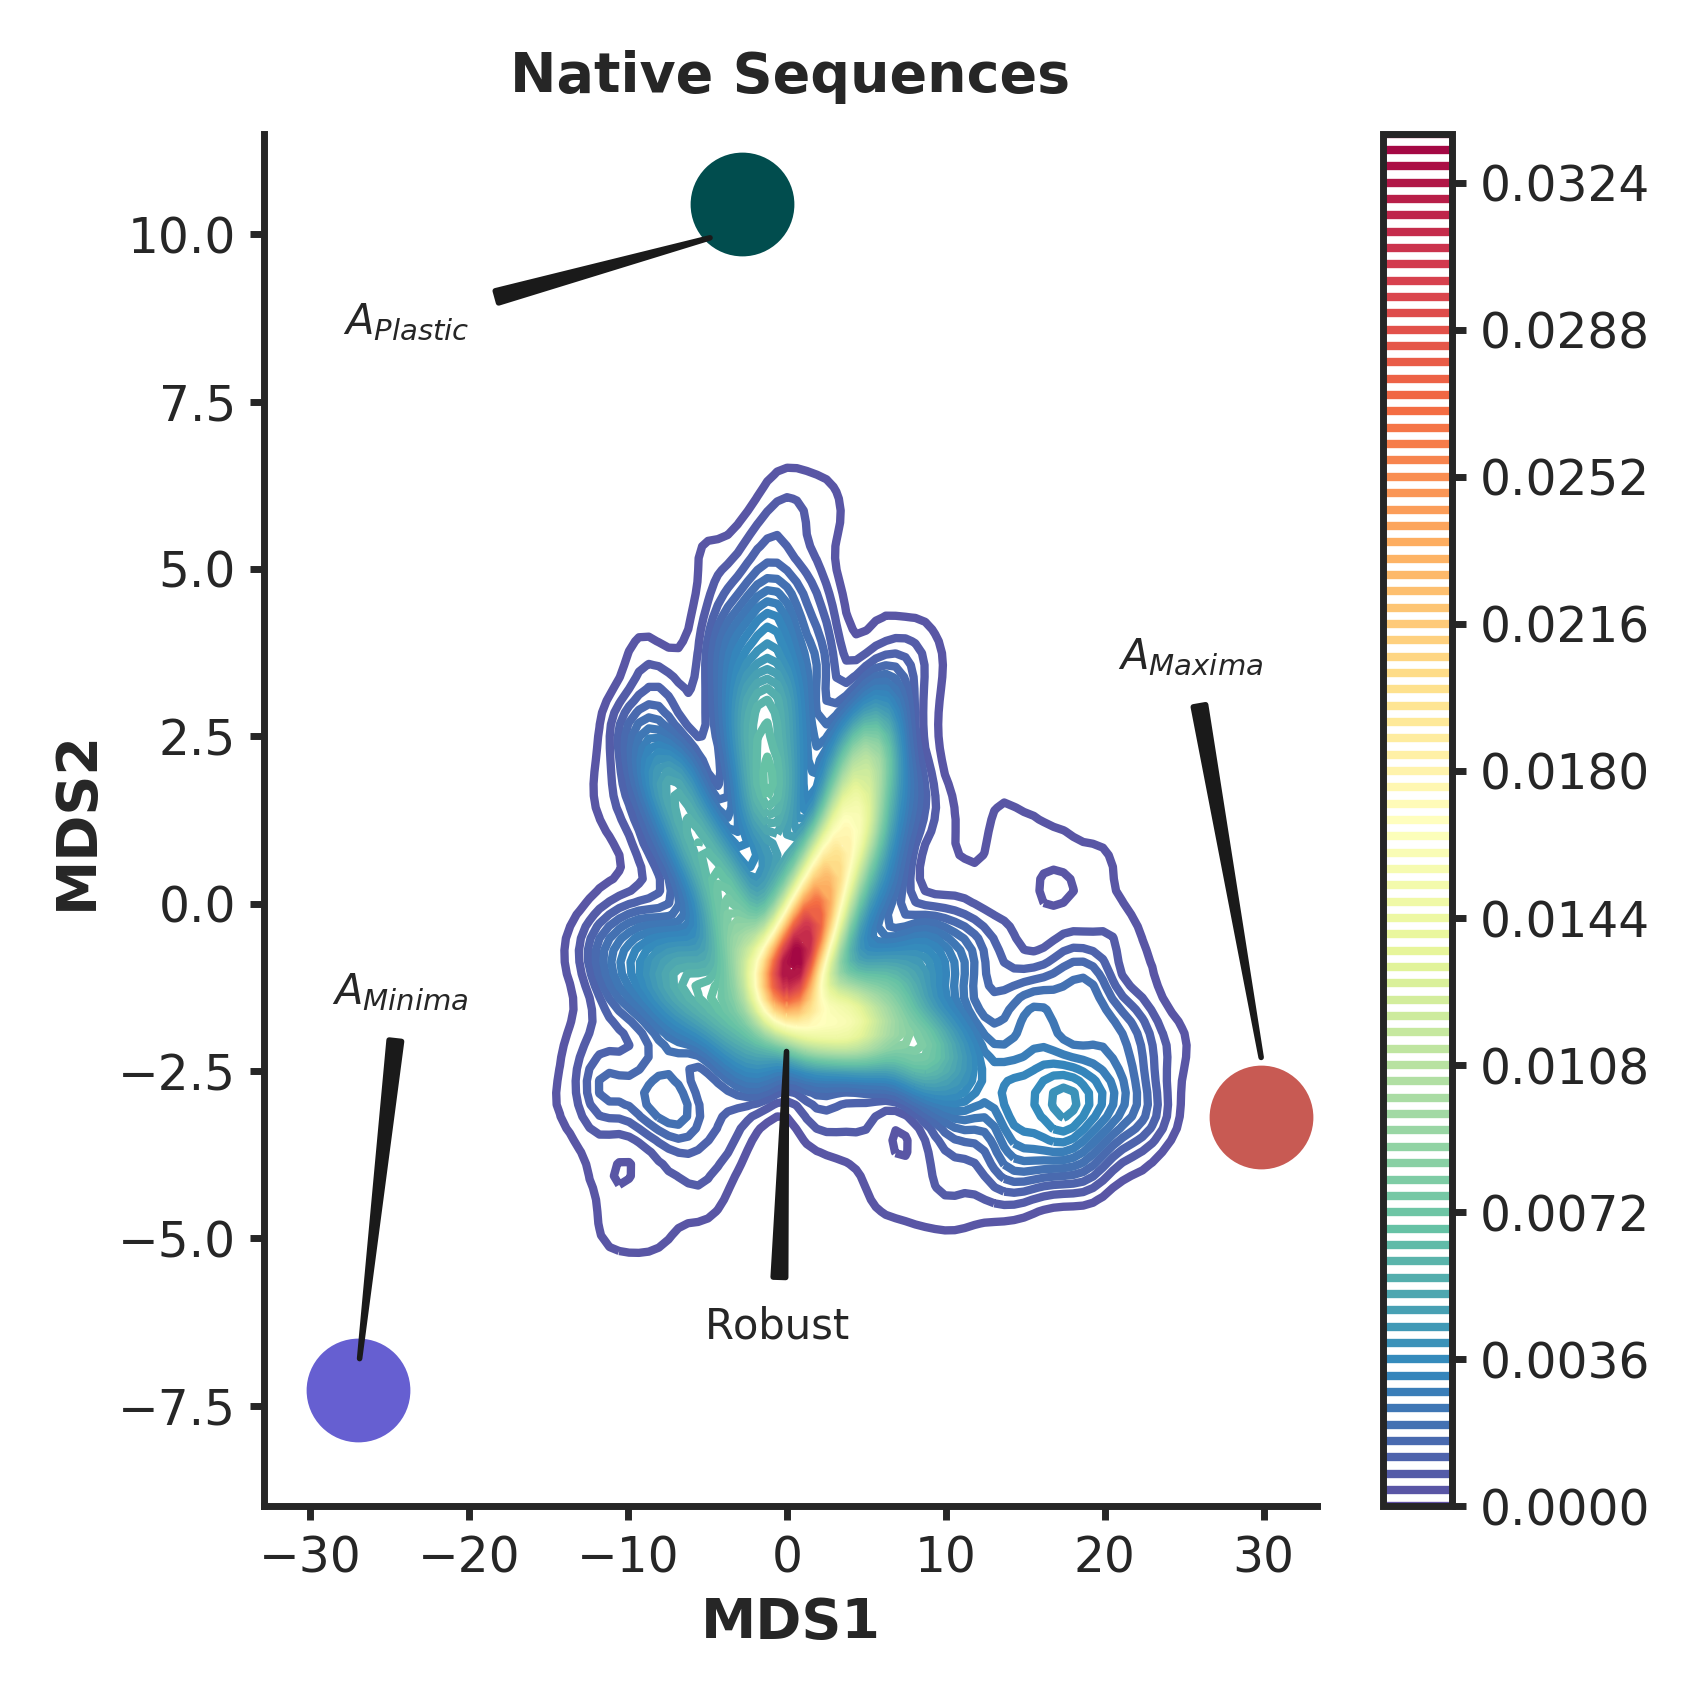

In [24]:
### Plot
#sns.set_palette( sns.color_palette('Spectral' )) 
at_colors = ['#665fd1' , '#c85a53', '#014d4e' ]
#color_palette = sns.choose_cubehelix_palette()

num_at=3

fig_file = "at_space_native"
fig=plt.figure(figsize=(3.5,3.5), dpi=500, facecolor='w', edgecolor='k')
#at_df = gc_balanced_random_at_df.loc[gc_balanced_random_at_df.iloc[0:len(ortho_at_df)].index] #ortho_at_df #random_at_df#
#at_df = random_at_df.loc[random_at_df.iloc[0:len(ortho_at_df)].index] #ortho_at_df #random_at_df#
at_df = native_at_df #random_at_df#


if 0 :
    MDS1_nonunique_list = []
    MDS2_nonunique_list = []

    for i in tqdm(at_df.index) : 
        MDS1_nonunique_list +=  list(np.tile(at_df.loc[i,'MDS1'] , 2) ) # at_df.loc[i,'num_isolates'])
        MDS2_nonunique_list +=  list(np.tile(at_df.loc[i,'MDS2'] , 2)  )# at_df.loc[i,'num_isolates'])



    #plt.hexbin(at_df['MDS1'] , at_df['MDS2'],gridsize=250, bins='log', mincnt=1,
    #          cmap = sns.dark_palette("pale orange", input="xkcd" , reverse=False, as_cmap=1))
    sns.kdeplot(MDS1_nonunique_list, MDS2_nonunique_list, 
                cmap = sns.diverging_palette(240, 10, n=10 , as_cmap=1 ,center="dark") ,
                n_levels=100, shade=False);

if 1 : 
    sns.kdeplot(at_df['MDS1'], at_df['MDS2'], 
                    cmap = 'Spectral_r' , cbar=1,
                    n_levels=100, shade=False);
    
if 0 :
    sns.jointplot(at_df['MDS1'], at_df['MDS2'], kind="hex",bins=1000,mincnt=1,
                  cmap = sns.diverging_palette(240, 10, n=10 , as_cmap=1 ,center="dark"))

#sns.jointplot(at_df['MDS1'], at_df['MDS2'], kind='hex')

if 1 : 
    for at in range(num_at) : 
        plt.scatter(Y_mds_ats[at,0], Y_mds_ats[at,1], s=200, c=at_colors[at], zorder=3 , marker='o')
        #plt.text(Y_mds_ats[at,0], Y_mds_ats[at,1], at+1, horizontalalignment='center', verticalalignment='center', 
        #     fontdict={'color': 'white','size':10,'weight':'bold'}, zorder=4)

    plt.scatter(Y_mds_ats[0,0], Y_mds_ats[0,1]-5, s=1, c='w', zorder=3)


#plt.scatter(cleft[0][0], cleft[0][1], s=200, c='w', zorder=3 , marker='o')

#TDH3 = ortho_at_df[ortho_at_df.proName=='YGR192C.2'].loc[:,['MDS1','MDS2']].values

#plt.scatter(TDH3[:,0] , TDH3[:,1])

### Axes adjustments and Titles

ax = plt.gca()
#ax.get_legend().remove()

ax.annotate('Robust', xy=(0, -2),  xycoords='data', fontsize=6,
            xytext=(4, -6), textcoords='data',
            arrowprops=dict(arrowstyle='wedge' , color='k'),
            horizontalalignment='right', verticalalignment='top'
            )
if 1 :
    ax.annotate('$A_{Plastic}$', xy=(-4, 10),  xycoords='data', fontsize=6,
                xytext=(-20, 9), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )

    ax.annotate('$A_{Maxima}$', xy=(30, -2.5),  xycoords='data', fontsize=6,
                xytext=(30, 4), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )


    ax.annotate('$A_{Minima}$', xy=(-27, -7),  xycoords='data', fontsize=6,
                xytext=(-20, -1), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )



ax.set_xlabel("MDS1"  )
ax.set_ylabel("MDS2")
ax.set_title("Native Sequences")

#ax.set_xticks([])
#ax.set_yticks([])
#ax.autoscale(enable=True, axis='x', tight=True)
#ax.autoscale(enable=True, axis='y', tight=True)
#plt.draw()
#ax.set_xlim(xmin=-14,xmax=6)
ax.set_ylim(ymin=-9,ymax=11.5)


plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")


plt.show()



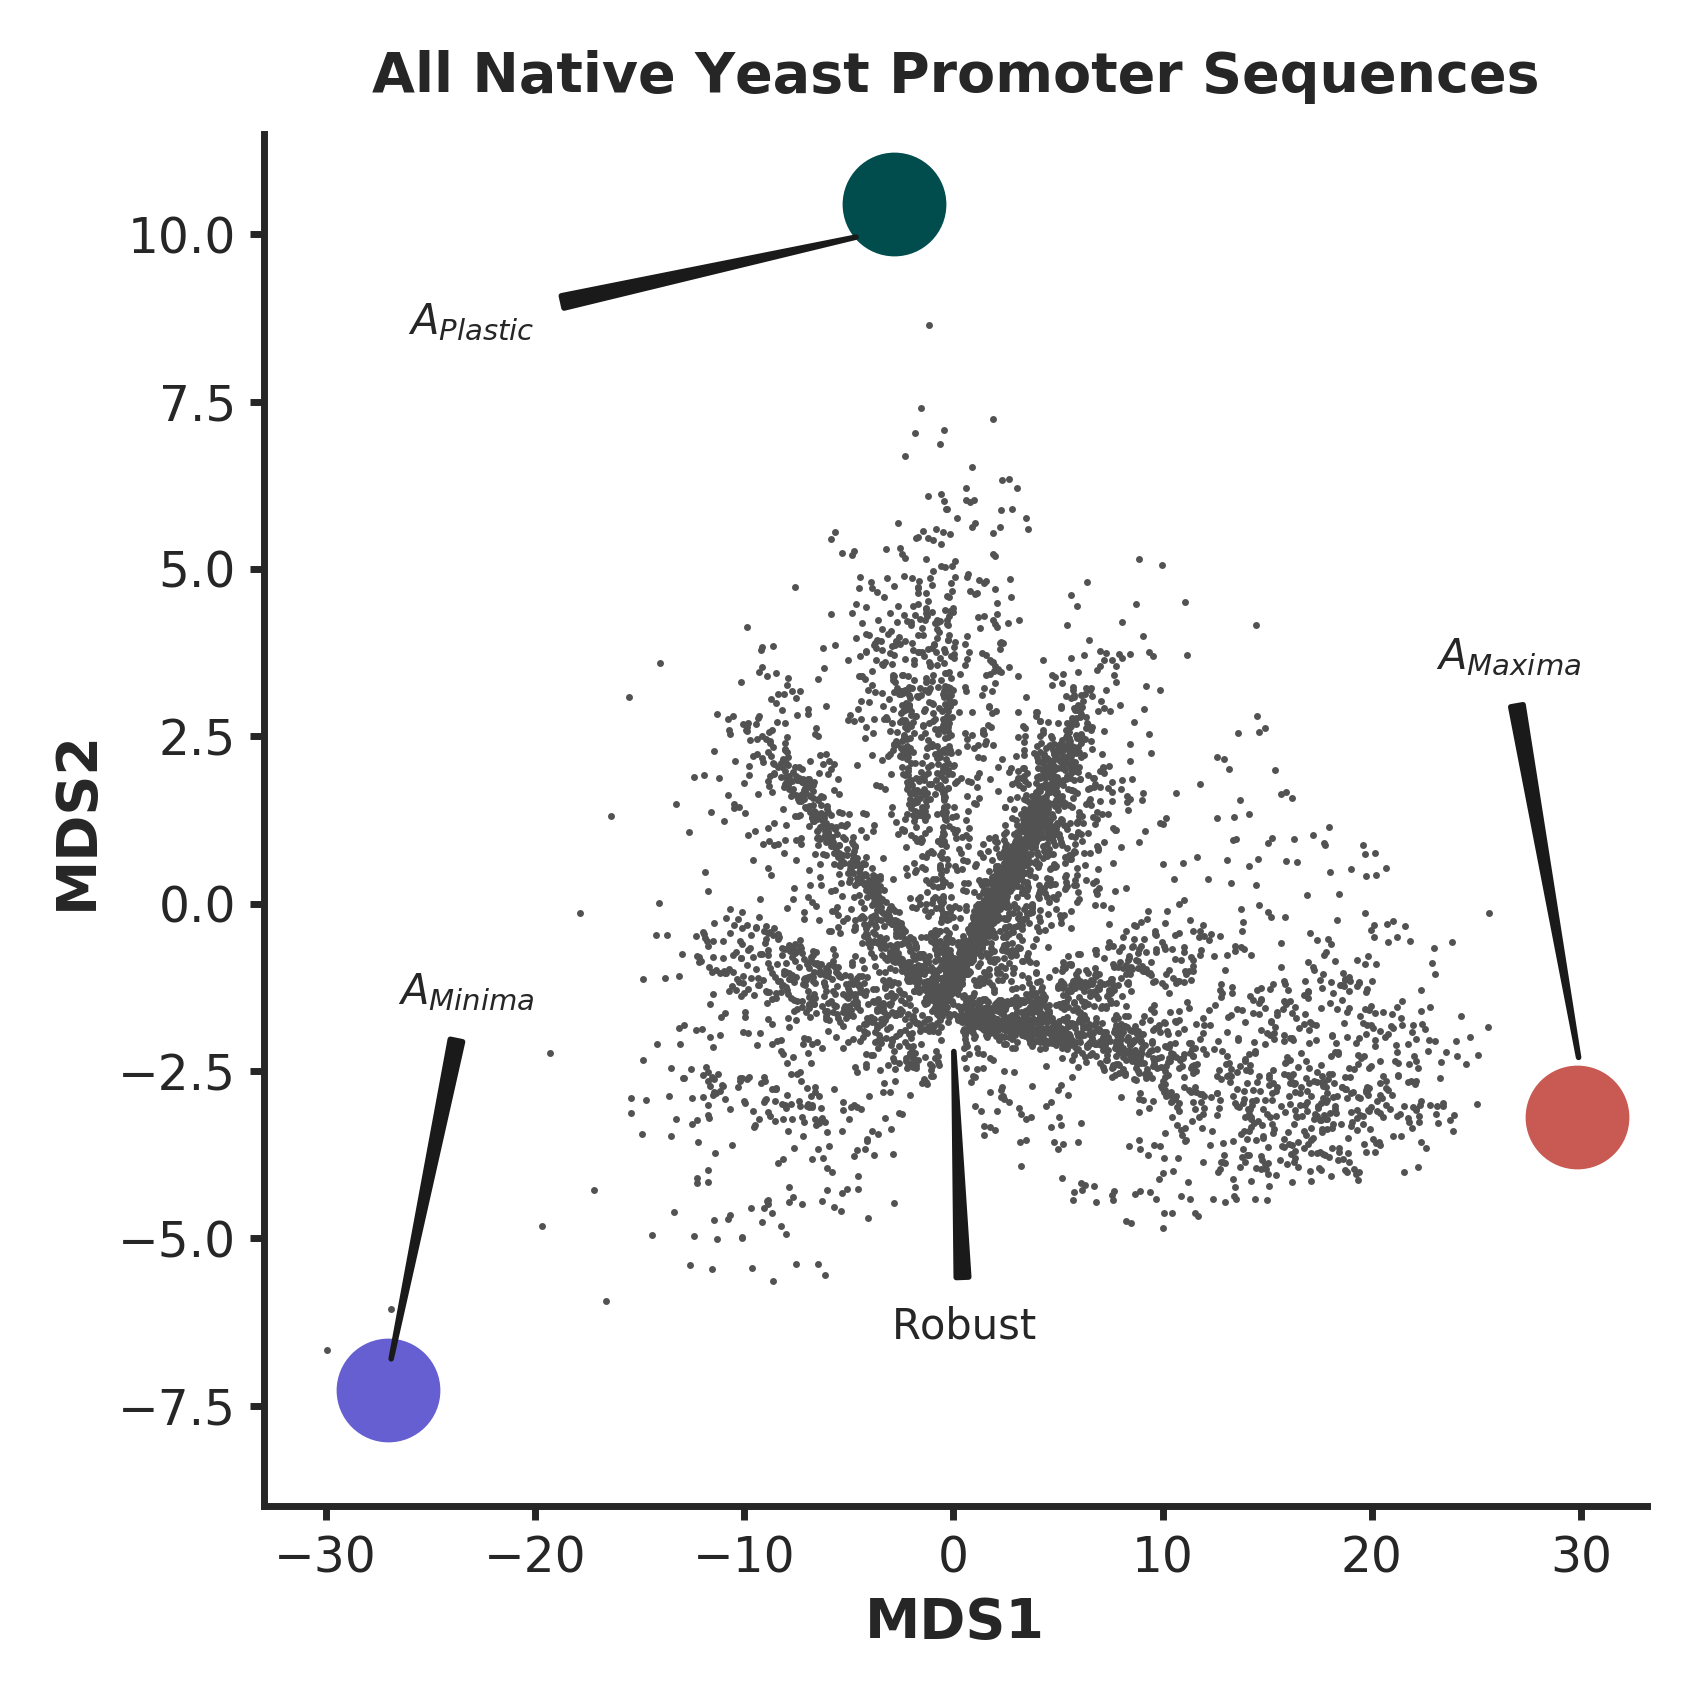

In [22]:
### Plot
#sns.set_palette( sns.color_palette('Spectral' )) 
at_colors = ['#665fd1' , '#c85a53', '#014d4e' ]
#color_palette = sns.choose_cubehelix_palette()

num_at=3

fig_file = "fig4b"
fig=plt.figure(figsize=(3.5,3.5), dpi=500, facecolor='w', edgecolor='k')
#at_df = gc_balanced_random_at_df.loc[gc_balanced_random_at_df.iloc[0:len(ortho_at_df)].index] #ortho_at_df #random_at_df#
#at_df = random_at_df.loc[random_at_df.iloc[0:len(ortho_at_df)].index] #ortho_at_df #random_at_df#
at_df = native_at_df #random_at_df#


if 0 :
    MDS1_nonunique_list = []
    MDS2_nonunique_list = []

    for i in tqdm(at_df.index) : 
        MDS1_nonunique_list +=  list(np.tile(at_df.loc[i,'MDS1'] , 2) ) # at_df.loc[i,'num_isolates'])
        MDS2_nonunique_list +=  list(np.tile(at_df.loc[i,'MDS2'] , 2)  )# at_df.loc[i,'num_isolates'])



    #plt.hexbin(at_df['MDS1'] , at_df['MDS2'],gridsize=250, bins='log', mincnt=1,
    #          cmap = sns.dark_palette("pale orange", input="xkcd" , reverse=False, as_cmap=1))
    sns.kdeplot(MDS1_nonunique_list, MDS2_nonunique_list, 
                cmap = sns.diverging_palette(240, 10, n=10 , as_cmap=1 ,center="dark") ,
                n_levels=100, shade=False);

plt.scatter(at_df['MDS1'], at_df['MDS2'],c='#525252' , s=1,rasterized=1, linewidths=0 );

#specific_at_df = at_df[at_df.proName==fig_file]
#plt.scatter(specific_at_df['MDS1'], specific_at_df['MDS2'],c='#dd1c77' , marker='8' , s=50,edgecolor='#525252');

if 1 : 
    for at in range(num_at) : 
        plt.scatter(Y_mds_ats[at,0], Y_mds_ats[at,1], s=200, c=at_colors[at], zorder=3 , marker='o')
        #plt.text(Y_mds_ats[at,0], Y_mds_ats[at,1], at+1, horizontalalignment='center', verticalalignment='center', 
        #     fontdict={'color': 'white','size':10,'weight':'bold'}, zorder=4)

    plt.scatter(Y_mds_ats[0,0], Y_mds_ats[0,1]-5, s=1, c='w', zorder=3)


#plt.scatter(cleft[0][0], cleft[0][1], s=200, c='w', zorder=3 , marker='o')

#TDH3 = ortho_at_df[ortho_at_df.proName=='YGR192C.2'].loc[:,['MDS1','MDS2']].values

#plt.scatter(TDH3[:,0] , TDH3[:,1])

### Axes adjustments and Titles

ax = plt.gca()
#ax.get_legend().remove()

ax.annotate('Robust', xy=(0, -2),  xycoords='data', fontsize=6,
            xytext=(4, -6), textcoords='data',
            arrowprops=dict(arrowstyle='wedge' , color='k'),
            horizontalalignment='right', verticalalignment='top'
            )
if 1 :
    ax.annotate('$A_{Plastic}$', xy=(-4, 10),  xycoords='data', fontsize=6,
                xytext=(-20, 9), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )

    ax.annotate('$A_{Maxima}$', xy=(30, -2.5),  xycoords='data', fontsize=6,
                xytext=(30, 4), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )


    ax.annotate('$A_{Minima}$', xy=(-27, -7),  xycoords='data', fontsize=6,
                xytext=(-20, -1), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )



ax.set_xlabel("MDS1"  )
ax.set_ylabel("MDS2")
ax.set_title("All Native Yeast Promoter Sequences")

#ax.set_xticks([])
#ax.set_yticks([])
#ax.autoscale(enable=True, axis='x', tight=True)
#ax.autoscale(enable=True, axis='y', tight=True)
#plt.draw()
#ax.set_xlim(xmin=-14,xmax=6)
ax.set_ylim(ymin=-9,ymax=11.5)


plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")


plt.show()




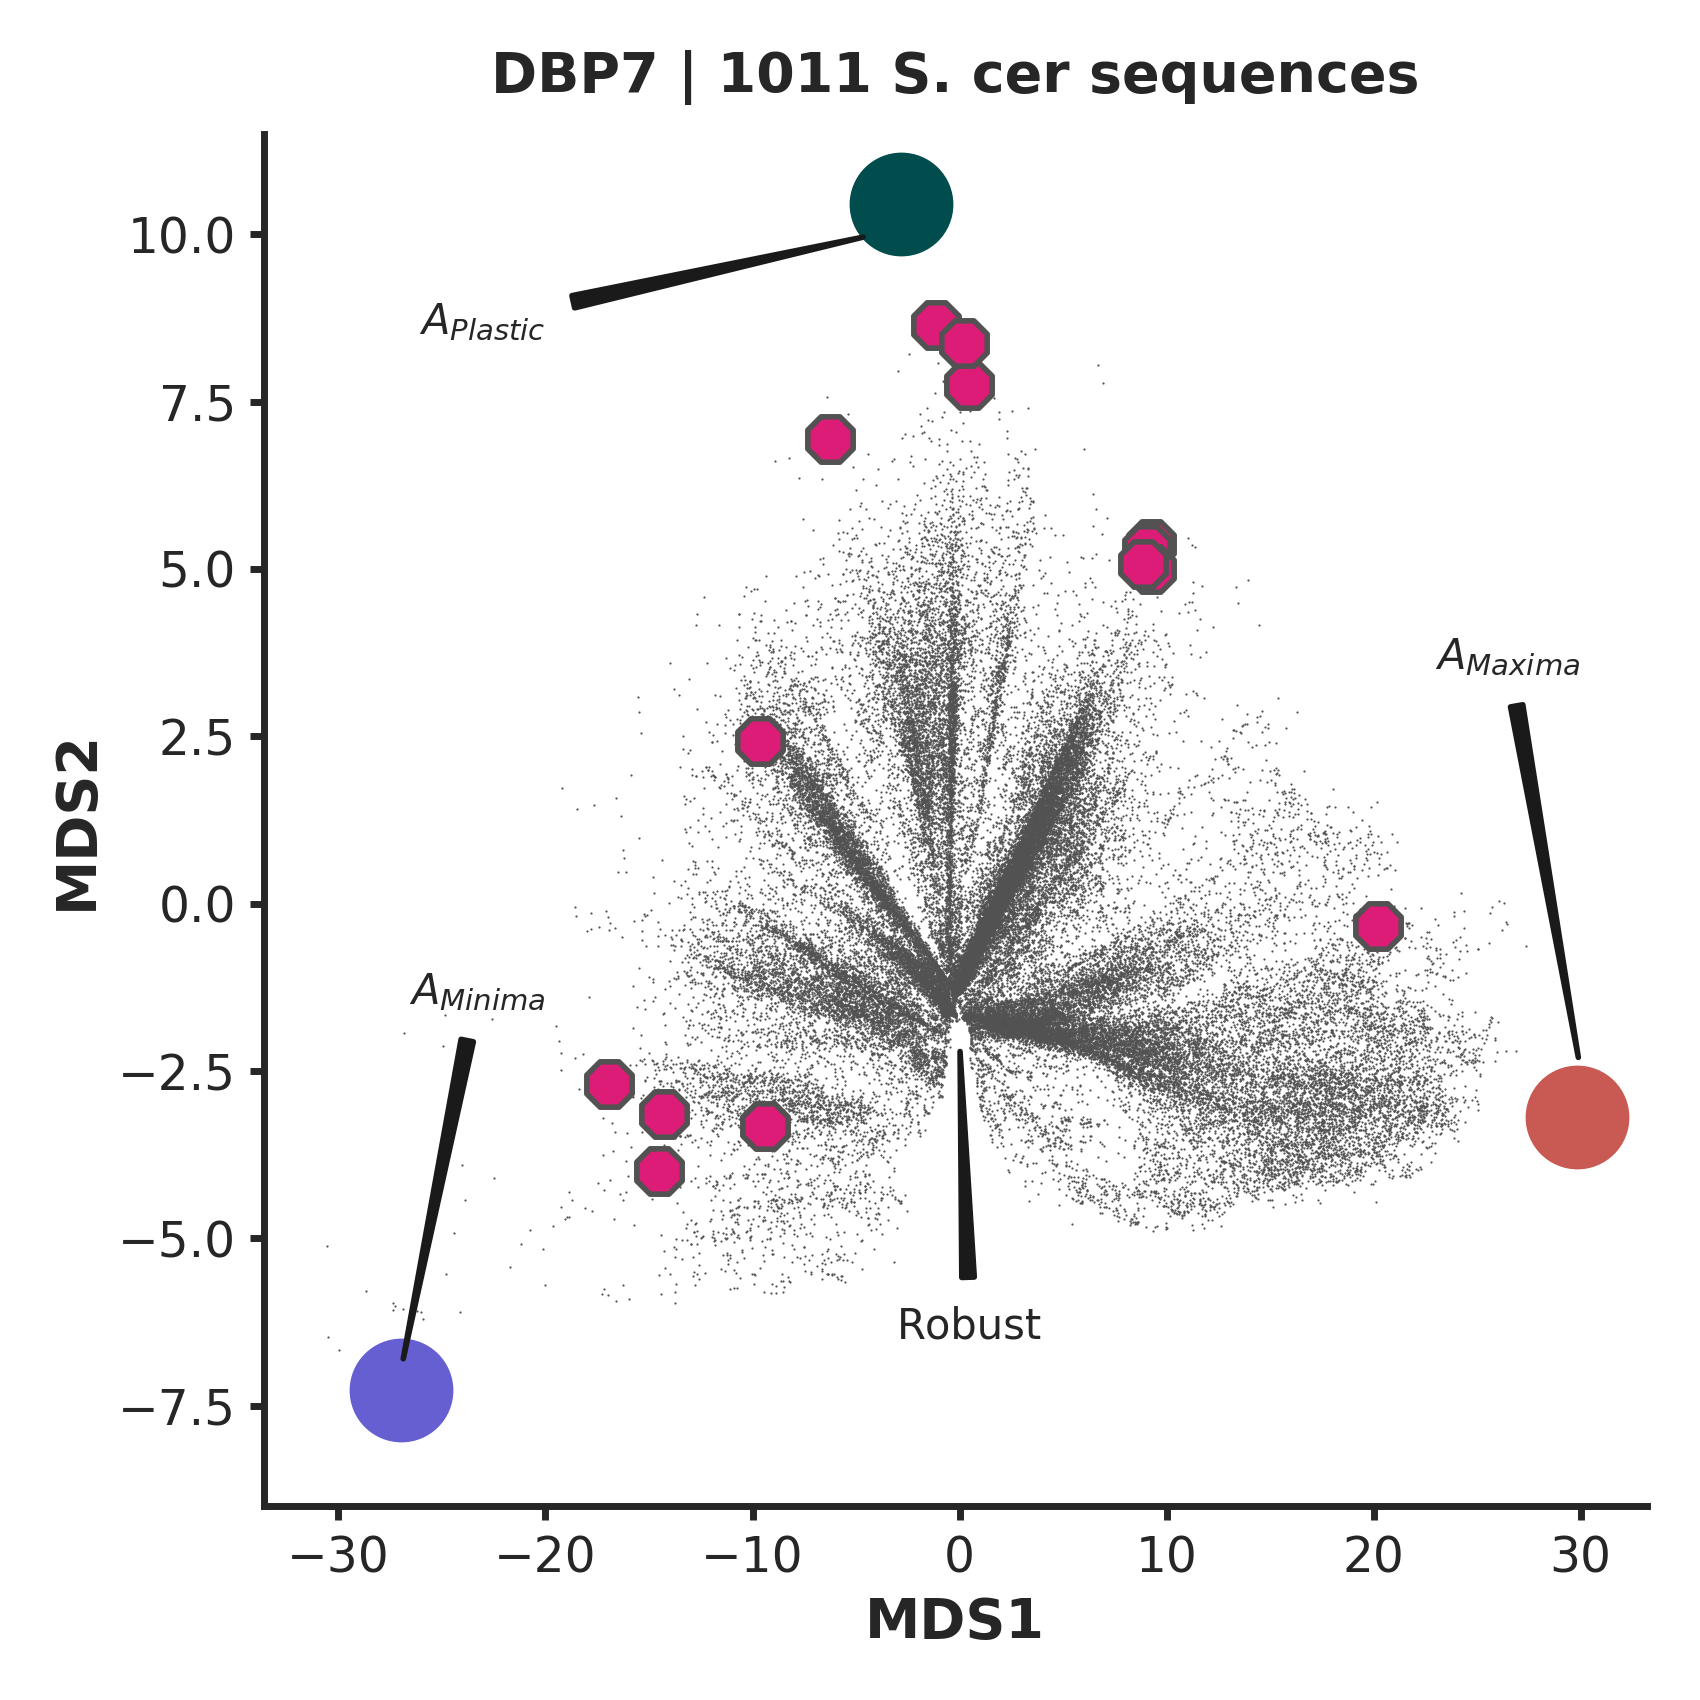

In [17]:
### Plot
#sns.set_palette( sns.color_palette('Spectral' )) 
at_colors = ['#665fd1' , '#c85a53', '#014d4e' ]
#color_palette = sns.choose_cubehelix_palette()

num_at=3

fig_file = "YKR024C.2"
fig=plt.figure(figsize=(3.5,3.5), dpi=500, facecolor='w', edgecolor='k')
#at_df = gc_balanced_random_at_df.loc[gc_balanced_random_at_df.iloc[0:len(ortho_at_df)].index] #ortho_at_df #random_at_df#
#at_df = random_at_df.loc[random_at_df.iloc[0:len(ortho_at_df)].index] #ortho_at_df #random_at_df#
at_df = ortho_at_df #random_at_df#


if 0 :
    MDS1_nonunique_list = []
    MDS2_nonunique_list = []

    for i in tqdm(at_df.index) : 
        MDS1_nonunique_list +=  list(np.tile(at_df.loc[i,'MDS1'] , 2) ) # at_df.loc[i,'num_isolates'])
        MDS2_nonunique_list +=  list(np.tile(at_df.loc[i,'MDS2'] , 2)  )# at_df.loc[i,'num_isolates'])



    #plt.hexbin(at_df['MDS1'] , at_df['MDS2'],gridsize=250, bins='log', mincnt=1,
    #          cmap = sns.dark_palette("pale orange", input="xkcd" , reverse=False, as_cmap=1))
    sns.kdeplot(MDS1_nonunique_list, MDS2_nonunique_list, 
                cmap = sns.diverging_palette(240, 10, n=10 , as_cmap=1 ,center="dark") ,
                n_levels=100, shade=False);

plt.scatter(at_df['MDS1'], at_df['MDS2'],c='#525252' , s=0.1,rasterized=1, linewidths=0);

specific_at_df = ortho_at_df[ortho_at_df.proName==fig_file]
plt.scatter(specific_at_df['MDS1'], specific_at_df['MDS2'],c='#dd1c77' , marker='8' , s=50,edgecolor='#525252');

if 1 : 
    for at in range(num_at) : 
        plt.scatter(Y_mds_ats[at,0], Y_mds_ats[at,1], s=200, c=at_colors[at], zorder=3 , marker='o')
        #plt.text(Y_mds_ats[at,0], Y_mds_ats[at,1], at+1, horizontalalignment='center', verticalalignment='center', 
        #     fontdict={'color': 'white','size':10,'weight':'bold'}, zorder=4)

    plt.scatter(Y_mds_ats[0,0], Y_mds_ats[0,1]-5, s=1, c='w', zorder=3)


#plt.scatter(cleft[0][0], cleft[0][1], s=200, c='w', zorder=3 , marker='o')

#TDH3 = ortho_at_df[ortho_at_df.proName=='YGR192C.2'].loc[:,['MDS1','MDS2']].values

#plt.scatter(TDH3[:,0] , TDH3[:,1])

### Axes adjustments and Titles

ax = plt.gca()
#ax.get_legend().remove()

ax.annotate('Robust', xy=(0, -2),  xycoords='data', fontsize=6,
            xytext=(4, -6), textcoords='data',
            arrowprops=dict(arrowstyle='wedge' , color='k'),
            horizontalalignment='right', verticalalignment='top'
            )
if 1 :
    ax.annotate('$A_{Plastic}$', xy=(-4, 10),  xycoords='data', fontsize=6,
                xytext=(-20, 9), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )

    ax.annotate('$A_{Maxima}$', xy=(30, -2.5),  xycoords='data', fontsize=6,
                xytext=(30, 4), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )


    ax.annotate('$A_{Minima}$', xy=(-27, -7),  xycoords='data', fontsize=6,
                xytext=(-20, -1), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )



ax.set_xlabel("MDS1"  )
ax.set_ylabel("MDS2")
ax.set_title("DBP7 | 1011 S. cer sequences")

#ax.set_xticks([])
#ax.set_yticks([])
#ax.autoscale(enable=True, axis='x', tight=True)
#ax.autoscale(enable=True, axis='y', tight=True)
#plt.draw()
#ax.set_xlim(xmin=-14,xmax=6)
ax.set_ylim(ymin=-9,ymax=11.5)


plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")


plt.show()




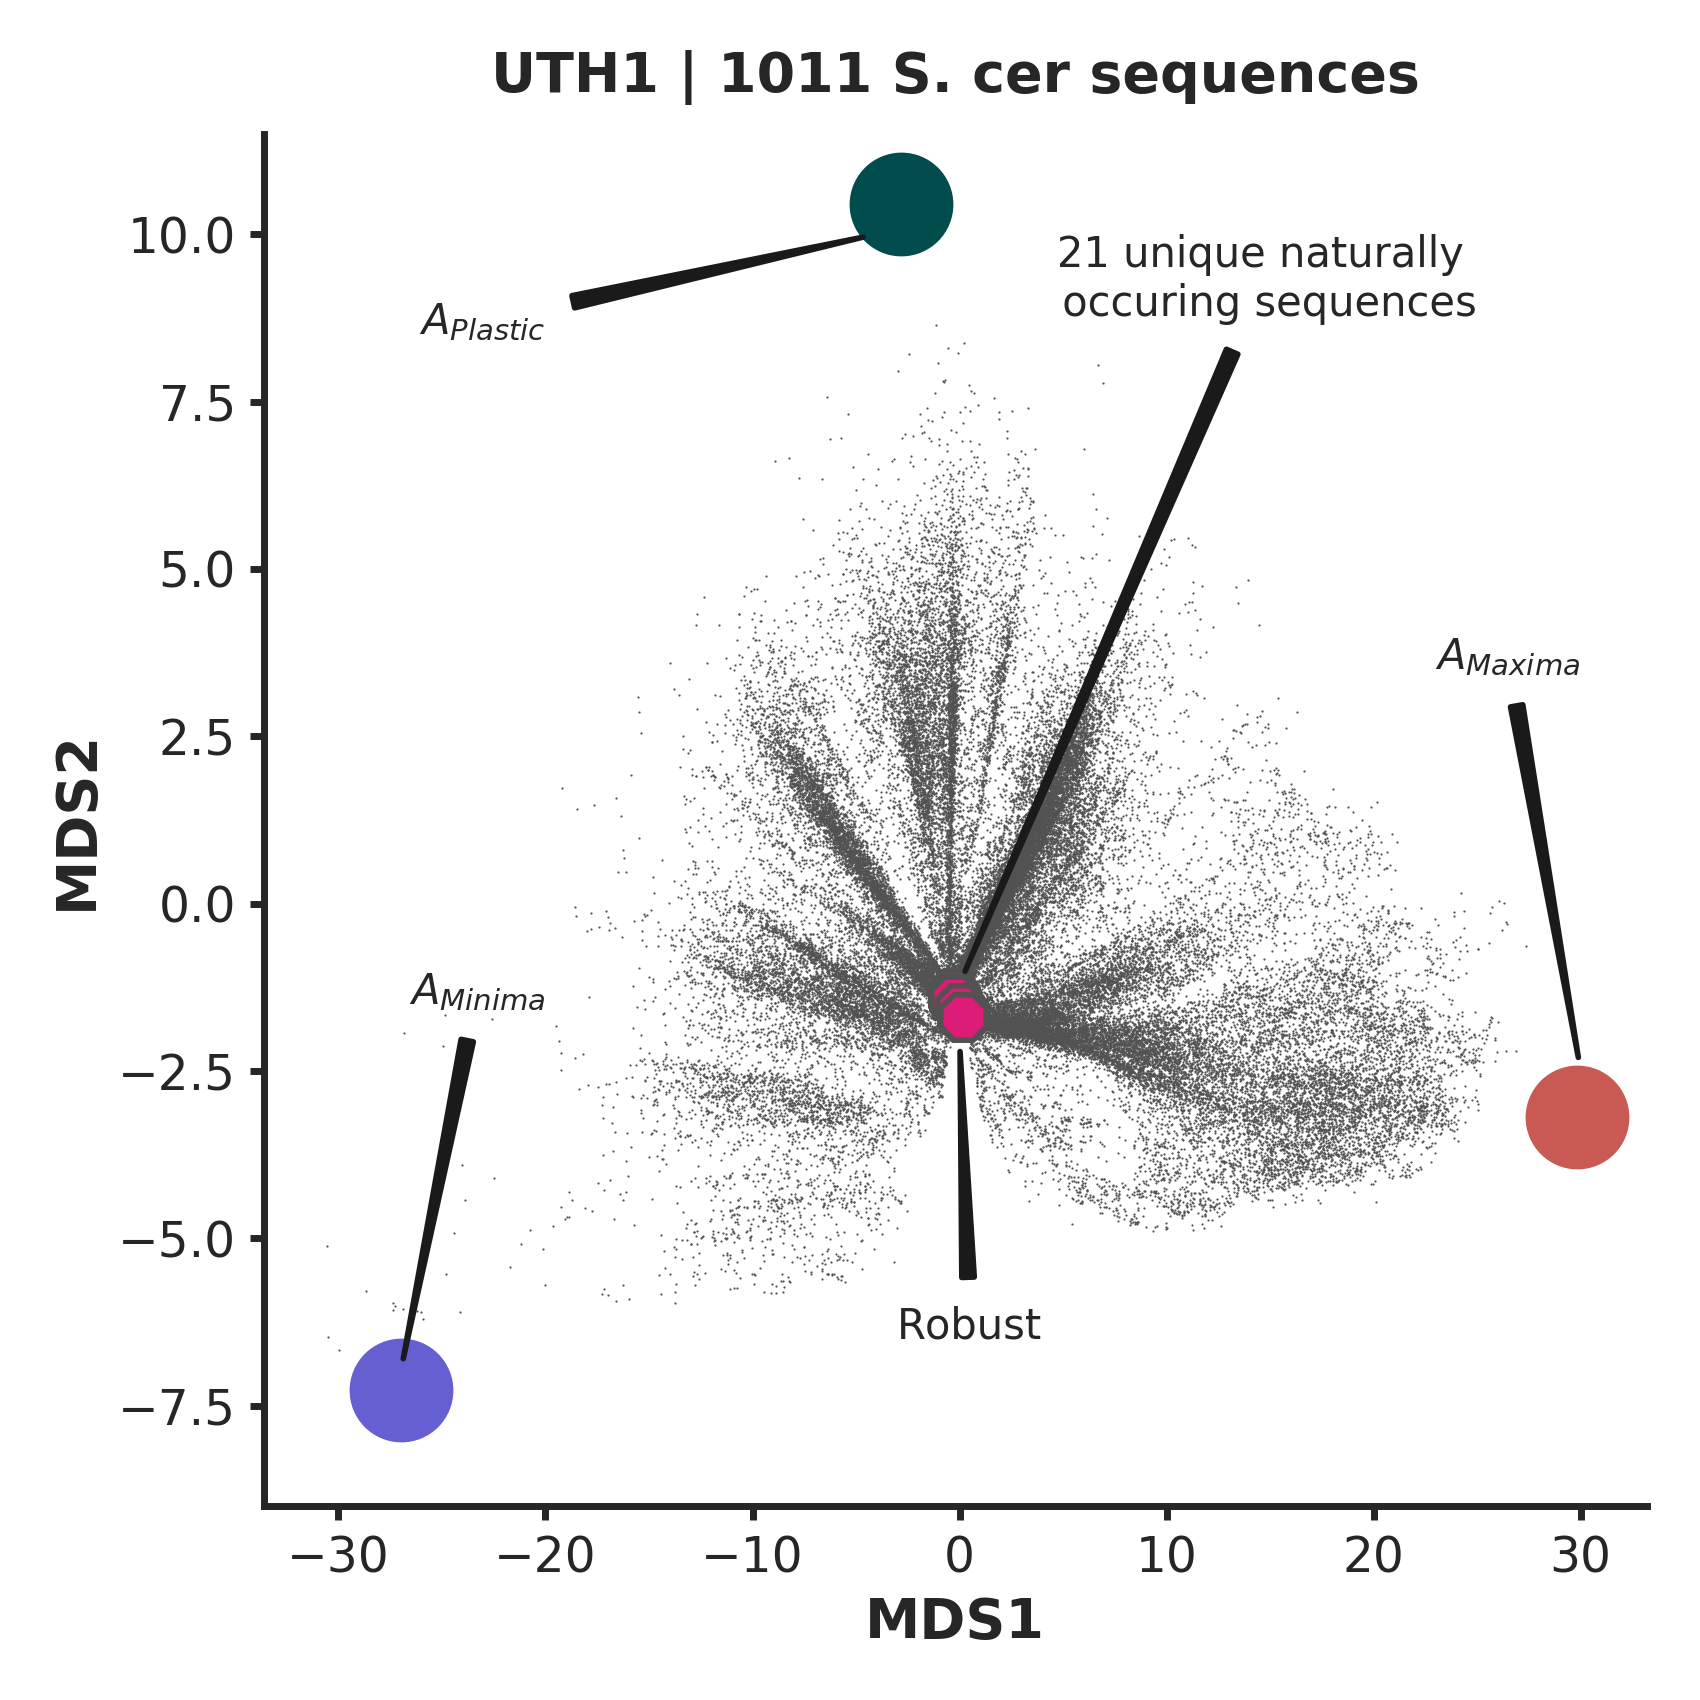

In [17]:
### Plot
#sns.set_palette( sns.color_palette('Spectral' )) 
at_colors = ['#665fd1' , '#c85a53', '#014d4e' ]
#color_palette = sns.choose_cubehelix_palette()

num_at=3

fig_file = "YKR042W.2"
fig=plt.figure(figsize=(3.5,3.5), dpi=500, facecolor='w', edgecolor='k')
#at_df = gc_balanced_random_at_df.loc[gc_balanced_random_at_df.iloc[0:len(ortho_at_df)].index] #ortho_at_df #random_at_df#
#at_df = random_at_df.loc[random_at_df.iloc[0:len(ortho_at_df)].index] #ortho_at_df #random_at_df#
at_df = ortho_at_df #random_at_df#


if 0 :
    MDS1_nonunique_list = []
    MDS2_nonunique_list = []

    for i in tqdm(at_df.index) : 
        MDS1_nonunique_list +=  list(np.tile(at_df.loc[i,'MDS1'] , 2) ) # at_df.loc[i,'num_isolates'])
        MDS2_nonunique_list +=  list(np.tile(at_df.loc[i,'MDS2'] , 2)  )# at_df.loc[i,'num_isolates'])



    #plt.hexbin(at_df['MDS1'] , at_df['MDS2'],gridsize=250, bins='log', mincnt=1,
    #          cmap = sns.dark_palette("pale orange", input="xkcd" , reverse=False, as_cmap=1))
    sns.kdeplot(MDS1_nonunique_list, MDS2_nonunique_list, 
                cmap = sns.diverging_palette(240, 10, n=10 , as_cmap=1 ,center="dark") ,
                n_levels=100, shade=False);

plt.scatter(at_df['MDS1'], at_df['MDS2'],c='#525252' , s=0.1,rasterized=1, linewidths=0);

specific_at_df = ortho_at_df[ortho_at_df.proName==fig_file]
plt.scatter(specific_at_df['MDS1'], specific_at_df['MDS2'],c='#dd1c77' , marker='8' , 
            s=50,edgecolor='#525252');

if 1 : 
    for at in range(num_at) : 
        plt.scatter(Y_mds_ats[at,0], Y_mds_ats[at,1], s=200, c=at_colors[at], zorder=3 , marker='o')
        #plt.text(Y_mds_ats[at,0], Y_mds_ats[at,1], at+1, horizontalalignment='center', verticalalignment='center', 
        #     fontdict={'color': 'white','size':10,'weight':'bold'}, zorder=4)

    plt.scatter(Y_mds_ats[0,0], Y_mds_ats[0,1]-5, s=1, c='w', zorder=3)


#plt.scatter(cleft[0][0], cleft[0][1], s=200, c='w', zorder=3 , marker='o')

#TDH3 = ortho_at_df[ortho_at_df.proName=='YGR192C.2'].loc[:,['MDS1','MDS2']].values

#plt.scatter(TDH3[:,0] , TDH3[:,1])

### Axes adjustments and Titles
ax = plt.gca()
#ax.get_legend().remove()

ax.annotate('Robust', xy=(0, -2),  xycoords='data', fontsize=6,
            xytext=(4, -6), textcoords='data',
            arrowprops=dict(arrowstyle='wedge' , color='k'),
            horizontalalignment='right', verticalalignment='top'
            )
if 1 :
    ax.annotate('$A_{Plastic}$', xy=(-4, 10),  xycoords='data', fontsize=6,
                xytext=(-20, 9), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )

    ax.annotate('$A_{Maxima}$', xy=(30, -2.5),  xycoords='data', fontsize=6,
                xytext=(30, 4), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )


    ax.annotate('$A_{Minima}$', xy=(-27, -7),  xycoords='data', fontsize=6,
                xytext=(-20, -1), textcoords='data',
                arrowprops=dict(arrowstyle='wedge' , color='k'),
                horizontalalignment='right', verticalalignment='top'
                )




ax.annotate('21 unique naturally \n occuring sequences', xy=(0, -1.2),  xycoords='data', fontsize=6,
            xytext=(25, 10), textcoords='data',
            arrowprops=dict(arrowstyle='wedge' , color='k'),
            horizontalalignment='right', verticalalignment='top'
            )



ax.set_xlabel("MDS1"  )
ax.set_ylabel("MDS2")
ax.set_title("UTH1 | 1011 S. cer sequences")

#ax.set_xticks([])
#ax.set_yticks([])
#ax.autoscale(enable=True, axis='x', tight=True)
#ax.autoscale(enable=True, axis='y', tight=True)
#plt.draw()
#ax.set_xlim(xmin=-14,xmax=6)
ax.set_ylim(ymin=-9,ymax=11.5)


plt.savefig("%s.svg" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.pdf" % (fig_file,), bbox_inches="tight")
plt.savefig("%s.png" % (fig_file,), bbox_inches="tight")


plt.show()



